In [127]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [128]:
cwd = os.getcwd()
cwd_ujoin = cwd.split("\\")[:-2]
basedir = "\\".join(cwd_ujoin)
sys.path.append(basedir)

In [129]:
def rw_sat_dynamics(q, w, rws, T_mtr, T_ext, gs_hat, I_SRW, J_s):
    ws = gs_hat.T@w

    print(f"ws: {ws}")
    qdot = 0.5*np.array([
        [0,    -w[0], -w[1], -w[2]],
        [w[0],     0,  w[2], -w[1]],
        [w[1], -w[2],     0,  w[0]],
        [w[2],  w[1], -w[0],     0]
    ])@q
    print(f"motor component wdot: {np.cross(w, J_s*gs_hat*ws*rws)}")
    wdot = np.linalg.inv(I_SRW)@(-np.cross(w, I_SRW@w) - np.cross(w, J_s*gs_hat*ws*rws) - T_mtr*gs_hat + T_ext)
    rws_dot = T_mtr/J_s - gs_hat.T@wdot
    print(f"rx wheel acc: {rws_dot}")
    return qdot, wdot, rws_dot

In [130]:
def xdot(x, u_mtr, u_ext, gs_hat, I_SRW, J_s):
    qdot, wdot, rws_dot = rw_sat_dynamics(x[:4], x[4:7], x[7], u_mtr, u_ext, gs_hat, I_SRW, J_s)
    return np.hstack((qdot, wdot, rws_dot))

In [131]:
def predict(x, u_mtr, u_ext, gs_hat, I_SRW, J_s, start, end, **solver_opts):
    fx = lambda t, y: xdot(y, u_mtr, u_ext, gs_hat, I_SRW, J_s)
    sol = solve_ivp(fx, [start, end], x, rtol = 1e-5, **solver_opts)
    return sol.y.flatten()

### Define Geometry

In [132]:
# moment of inertia of satellite (including RW assembly)
l, w, h = 10e-2, 10e-2, 10e-2
motor_mass = 250e-3 # 100grams
r_m2com = 5e-2 # 5cm
motor_extra_inertia = 2*motor_mass*r_m2com**2 # assuming offset mass at opposite side
motor_extra_inertia

0.0012500000000000002

In [133]:
base_axial_inertia = (800/3)*(l/2)**2
I_sat = np.array([
    [base_axial_inertia+motor_extra_inertia, 0.0, 0.0],
    [0.0, base_axial_inertia+motor_extra_inertia, 0.0],
    [0.0, 0.0, base_axial_inertia]
])
I_sat

array([[0.66791667, 0.        , 0.        ],
       [0.        , 0.66791667, 0.        ],
       [0.        , 0.        , 0.66666667]])

In [134]:
m_disc = 100e-3
r_disc = 0.5e-2
I_disc_s = (m_disc*r_disc**2)/2
I_disc_t = I_disc_s/2
J_s = I_disc_s
J_t = I_disc_t
J_g = I_disc_t

In [135]:
J_s

1.25e-06

In [136]:
gs_hat = np.array([0.0, 0.0, 1.0])
gt_hat = np.array([0.0, 1.0, 0.0])
gg_hat = np.array([1.0, 0.0, 0.0])

In [137]:
I_SRW = I_sat + J_t*gt_hat.reshape((3,1))@gt_hat.reshape((1,3)) + J_g*gg_hat.reshape((3,1))@gg_hat.reshape((1,3))
I_SRW

array([[0.66791729, 0.        , 0.        ],
       [0.        , 0.66791729, 0.        ],
       [0.        , 0.        , 0.66666667]])

### Define Initial Conditions

In [138]:
q0 = [1, 0, 0, 0]
w0 = [np.deg2rad(0.001), np.deg2rad(0.001), np.deg2rad(1.0)]
rws0 = 0.0 # reaction wheel speed
x0 = np.hstack((q0, w0, rws0))
u0_ext = np.array([0.0, 0.0, 0.0])
u0_mtr = 0.00001


In [139]:
w0

[1.7453292519943296e-05, 1.7453292519943296e-05, 0.017453292519943295]

In [140]:
t_start = 0
t_end = 180
dt = 1.0
t_vec = np.arange(t_start, t_end + dt, dt)

In [141]:
x0.shape

(8,)

In [142]:
x = x0
u_ext = u0_ext
u_mtr = u0_mtr
x_history = np.zeros((len(t_vec), len(x)))
solver_opts = dict(t_eval=[0])

for idx, t in enumerate(t_vec):
    if idx%2:
        u_mtr = -u0_mtr # just once
    else:
        u_mtr = u0_mtr
    x_history[idx, :] = x
    start = t
    end = t + dt
    solver_opts['t_eval'] = [end]
    xnew = predict(x, u_mtr, u_ext, gs_hat, I_SRW, J_s, start, end, **solver_opts)

    x = xnew
    # x[:4] = x[:4]/np.linalg.norm(x[:4])

ws: 0.017453292519943295
motor component wdot: [0. 0. 0.]
rx wheel acc: 8.000015
ws: 0.017453290792780823
motor component wdot: [ 3.50749805e-16 -3.50749808e-16  0.00000000e+00]
rx wheel acc: 8.000015
ws: 0.01745325797669387
motor component wdot: [ 7.01498242e-15 -7.01498347e-15  0.00000000e+00]
rx wheel acc: 8.000015
ws: 0.017453240705069158
motor component wdot: [ 1.05224628e-14 -1.05224652e-14  0.00000000e+00]
rx wheel acc: 8.000015
ws: 0.017453154346945592
motor component wdot: [ 2.80597567e-14 -2.80597736e-14  0.00000000e+00]
rx wheel acc: 8.000015
ws: 0.017453138994390292
motor component wdot: [ 3.11774790e-14 -3.11774999e-14  0.00000000e+00]
rx wheel acc: 8.000015
ws: 0.017453119803696168
motor component wdot: [ 3.50746238e-14 -3.50746502e-14  0.00000000e+00]
rx wheel acc: 8.000015
ws: 0.017453119803696168
motor component wdot: [ 3.50746238e-14 -3.50746502e-14  0.00000000e+00]
rx wheel acc: 8.000015
ws: 0.017452774371201914
motor component wdot: [ 1.05221710e-13 -1.05221947e-13 

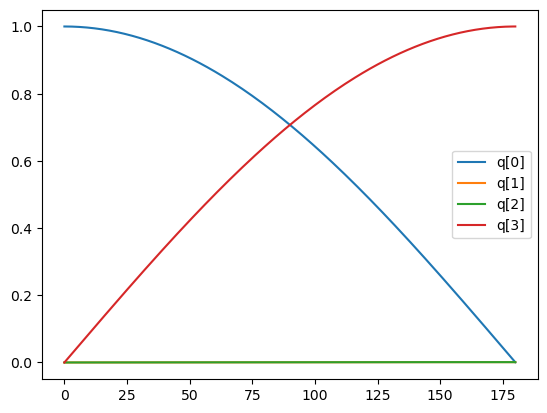

In [143]:
plt.plot(t_vec, x_history[:, :4])
plt.legend(["q[0]", "q[1]", "q[2]", "q[3]"])

(-0.5, 2.0)

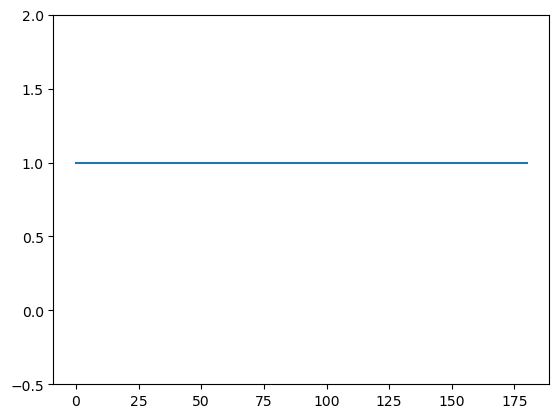

In [144]:
plt.plot(t_vec, np.linalg.norm(x_history[:, :4], axis=1))
plt.ylim(-0.5, 2)

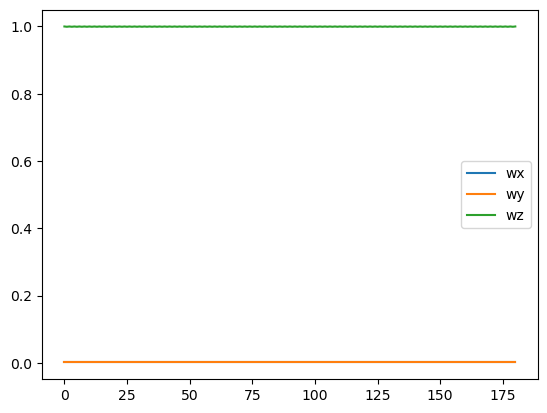

In [145]:
plt.plot(t_vec, np.rad2deg(x_history[:, 4:7]))
plt.legend(["wx", "wy", "wz"])

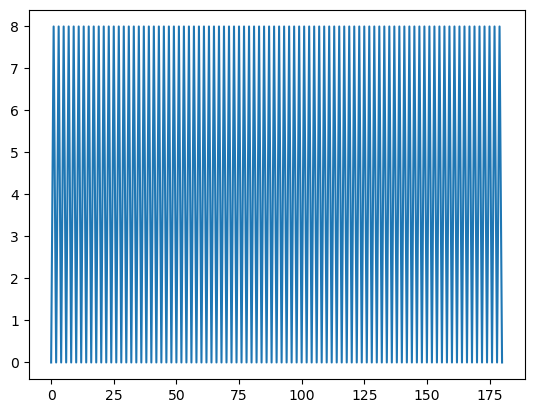

In [146]:
plt.plot(t_vec, x_history[:, 7])

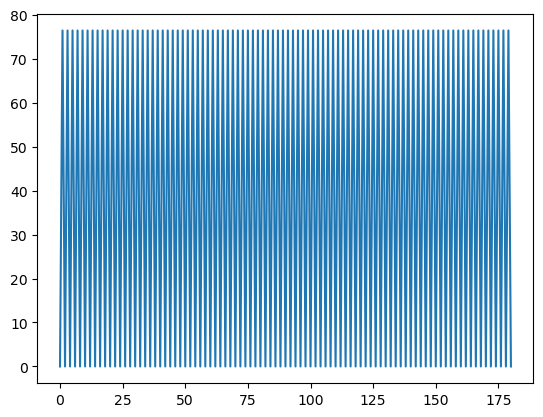

In [147]:
plt.plot(t_vec, x_history[:, 7]*(60/(2*np.pi)))

In [148]:
qi = q0
qc = x_history[90, :4]
qc

array([7.07344834e-01, 7.08489391e-04, 7.06417837e-04, 7.06867940e-01])

In [149]:
from attitude.parameters import quat2dcm

In [150]:
dcm0 = quat2dcm(q0)
dcm0

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [151]:
dcmf = quat2dcm(-np.array(q0))
dcmf

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [152]:
dcmc = quat2dcm(qc)
dcmc

array([[ 6.74432394e-04,  9.99999773e-01,  2.25485822e-06],
       [-9.99997771e-01,  6.74426532e-04,  2.00098086e-03],
       [ 2.00097889e-03, -3.60437951e-06,  9.99997998e-01]])